In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar
from six import print_

from utils import compute_mean_square_error, formatter
from generate_inputs import RUNS, A0_VALUES, DEFAULT_TIME, DEFAULT_DT, M_VALUES

In [2]:
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'brown', 'pink', 'gray', 'cyan']

In [3]:
print(f"A0 values: {A0_VALUES}")
print(f"M values: {M_VALUES}")

A0 values: [0.5 1.4 2.3 3.2 4.1 5. ]
M values: [80, 90, 100, 110, 120]


In [4]:
def calculate_q(exits_data, steady_state, min_q=0.0, max_q=2.0):
    filtered_data = exits_data[exits_data.index > steady_state]

    x_values = filtered_data.index
    y_values = filtered_data

    x0 = x_values[0]
    y0 = y_values.iloc[0]

    fit_x_values = x_values - x0
    fit_y_values = y_values - y0

    # Define the mean square error function for a given q
    def mse_for_q(q):
        return compute_mean_square_error(q, fit_x_values, fit_y_values)

    # Use minimize_scalar to find the best q
    result = minimize_scalar(mse_for_q, bounds=(min_q, max_q), method='bounded')

    best_q = result.x
    min_error = result.fun

    return x0, y0, best_q, min_error

# Ejercicio B

In [5]:
time_points = [i * DEFAULT_DT for i in range(int(DEFAULT_TIME / DEFAULT_DT))]

b_q_means = np.zeros(len(A0_VALUES))
b_q_std = np.zeros(len(A0_VALUES))

for i in range(len(A0_VALUES)):

    b_q_values = np.zeros(RUNS)
    b_errors = np.zeros(RUNS)

    print(time.time(), i)

    for j in range(RUNS):
        print(j, end='\r')
        exits_file = f"../outputs/2_{i}_{j}_exits.csv"
        exits_data = pd.read_csv(exits_file)
        # print(exits_data)
        exits_data["time"] = (exits_data["time"] / DEFAULT_DT).round() * DEFAULT_DT

        crossings_count = exits_data["time"].value_counts().reindex(time_points, fill_value=0).cumsum()

        _, _, q, error = calculate_q(crossings_count, 200.0)

        b_q_values[j] = q
        b_errors[j] = error

    b_q_means[i] = np.mean(b_q_values)
    b_q_std[i] = np.std(b_q_values)

1731003816.0401266 0
1731003823.6600056 1
1731003828.2937684 2
1731003832.8949683 3
1731003837.4792283 4
1731003842.041695 5


In [6]:
print(b_q_means)
print(b_q_std)

[0.56095317 0.7234062  0.94442435 1.18351982 1.21625637 1.57967309]
[0.14399221 0.14251371 0.13489534 0.32954133 0.07521055 0.138438  ]


In [19]:
b_q_means_fit = [b_q_mean - b_q_means[0] for b_q_mean in b_q_means]
b_a0_fit = [a0 - A0_VALUES[0] for a0 in A0_VALUES]

print(b_q_means_fit)
print(b_a0_fit)

b_possible_vals = np.linspace(-1.0, 3.0, 200)
errors = [compute_mean_square_error(b, b_a0_fit, b_q_means_fit) for b in b_possible_vals]

b_min_b_error_idx = np.argmin(errors)
b_min_b_error = errors[b_min_b_error_idx]
b_best_b = b_possible_vals[b_min_b_error_idx]

print(f"Best b: {b_best_b}")
print(f"Min error: {b_min_b_error}")

[np.float64(0.0), np.float64(0.16245302814413543), np.float64(0.3834711725306422), np.float64(0.6225666446339074), np.float64(0.6553031972581357), np.float64(1.0187199197267676)]
[np.float64(0.0), np.float64(0.8999999999999999), np.float64(1.7999999999999998), np.float64(2.7), np.float64(3.5999999999999996), np.float64(4.5)]
Best b: 0.20603015075376896
Min error: 0.003489047586648598


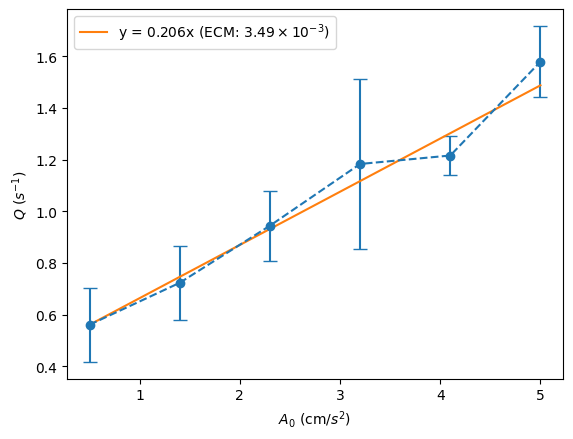

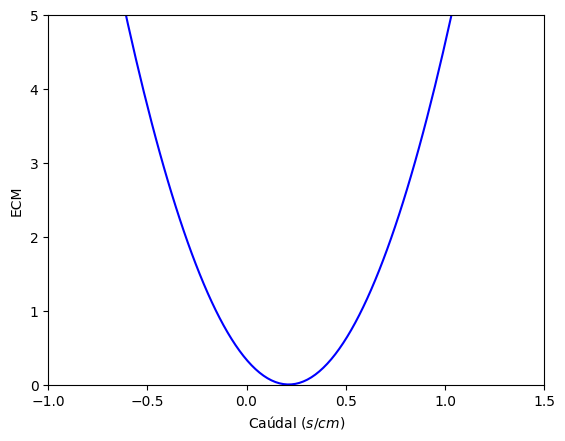

R: 4.853658536585363


<Figure size 640x480 with 0 Axes>

In [21]:
# Graph q_means vs a0 with error bars
# plt.scatter(A0_VALUES, b_q_means)
plt.errorbar(A0_VALUES, b_q_means, yerr=b_q_std, fmt='o--', capsize=5)
plt.plot(A0_VALUES, [b_best_b * (a0 - A0_VALUES[0]) + b_q_means[0] for a0 in A0_VALUES],
         label=f"y = {b_best_b:.3f}x (ECM: {formatter(b_min_b_error, None)})")
plt.legend(loc='upper left')
plt.xlabel("$A_0$ (cm/$s^2$)")
plt.ylabel("$Q$ ($s^{-1}$)")

plt.savefig("../analysis/q_vs_a0.png", dpi=300)
plt.show()
plt.clf()

plt.plot(b_possible_vals, errors, color='blue')
plt.xlabel("Caúdal ($s/cm$)")
plt.ylabel("ECM")
plt.xlim(-1.0, 1.5)
plt.ylim(0, 5.0)
plt.savefig("../analysis/q_vs_a0_error.png", dpi=300)
plt.show()
plt.clf()

# Q = m_p * a0 / R
# b = m_p / R
# R = m_p / b

print(f"R: {1 / b_best_b}")

# Ejercicio C

In [9]:
c_q_means = np.zeros((len(M_VALUES), len(A0_VALUES)))
c_q_std = np.zeros((len(M_VALUES), len(A0_VALUES)))

for i in range(len(M_VALUES)):
    for j in range(len(A0_VALUES)):
        c_q_values = np.zeros(RUNS)
        c_errors = np.zeros(RUNS)

        for k in range(RUNS):
            print(j, end='\r')
            exits_file = f"../outputs/3_{i}_{j}_{k}_exits.csv"
            exits_data = pd.read_csv(exits_file)
            # print(exits_data)
            exits_data["time"] = (exits_data["time"] / DEFAULT_DT).round() * DEFAULT_DT

            crossings_count = exits_data["time"].value_counts().reindex(time_points, fill_value=0).cumsum()

            _, _, q, error = calculate_q(crossings_count, 200.0)

            c_q_values[k] = q
            c_errors[k] = error

        c_q_means[i][j] = np.mean(c_q_values)
        c_q_std[i][j] = np.std(c_q_values)


In [10]:
print(c_q_means)
print(c_q_std)

[[0.86235907 1.25386984 1.60172737 1.55779394 1.91337979 1.94738499]
 [0.73456113 1.02491019 1.35696148 1.51974978 1.68286476 1.53681365]
 [0.62052909 0.76282068 1.11106177 1.27230638 1.26871961 1.27132742]
 [0.50372201 0.81666146 0.8208432  1.11743015 1.01978739 1.20219614]
 [0.37551911 0.51641115 0.73914622 0.867233   0.94530487 1.07074461]]
[[0.18308537 0.16681539 0.05285675 0.43364184 0.09660415 0.06594209]
 [0.18938142 0.42722559 0.43439876 0.34532463 0.26811039 0.30184175]
 [0.11072504 0.13974806 0.24638167 0.29962168 0.42642656 0.31208663]
 [0.08873927 0.14513762 0.04803928 0.1789397  0.17088236 0.32039537]
 [0.08761996 0.19380904 0.17779819 0.13964402 0.25265927 0.22499862]]


In [11]:
c_inv_resistance = np.zeros(len(M_VALUES))
c_inv_resistance_ecm = np.zeros(len(M_VALUES))

for i in range(len(M_VALUES)):
    c_q_means_fit = [c_q_mean - c_q_means[i][0] for c_q_mean in c_q_means[i]]
    c_a0_fit = [a0 - A0_VALUES[0] for a0 in A0_VALUES]


    def mse_for_c(c):
        return compute_mean_square_error(c, c_a0_fit, c_q_means_fit)


    result = minimize_scalar(mse_for_c, bounds=(0.0, 6.0), method='bounded')

    c_inv_resistance[i] = result.x
    c_inv_resistance_ecm[i] = result.fun


In [12]:
print(c_inv_resistance)
print(c_inv_resistance_ecm)

[0.27445989 0.23626652 0.18031197 0.16858461 0.16360724]
[0.0182715  0.02403843 0.01349076 0.0105298  0.00156126]


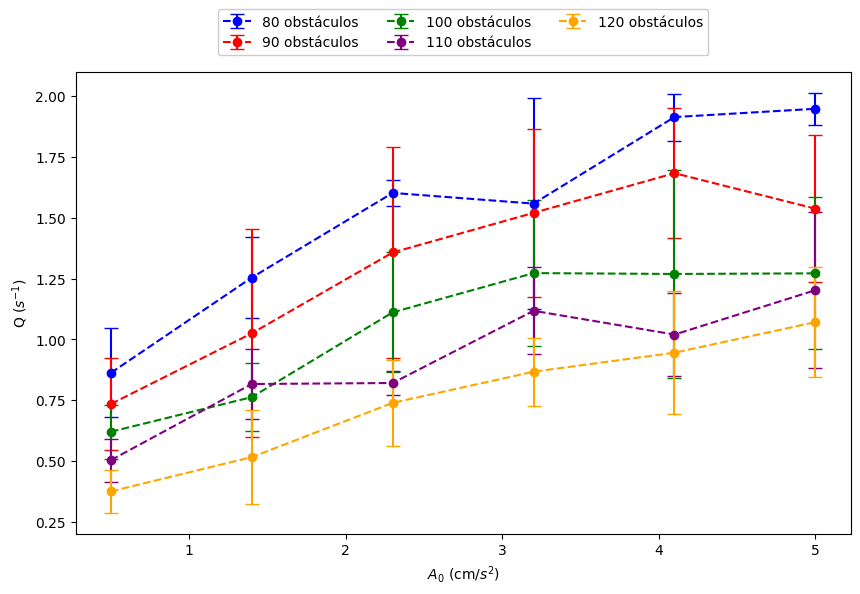

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10, 6))
for i in range(len(M_VALUES)):
    plt.errorbar(A0_VALUES, c_q_means[i], yerr=c_q_std[i], fmt='--o', capsize=5, label=f"{M_VALUES[i]} obstáculos", color=colors[i])
    # plt.plot(A0_VALUES, [c_inv_resistance[i] * (a0 - A0_VALUES[0]) + c_q_means[i][0] for a0 in A0_VALUES],
    #          label=f"y = {c_inv_resistance[i]:.3f}x (ECM: {formatter(c_inv_resistance_ecm[i],None)})",
    #          color=colors[i],)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), framealpha=1.0, ncol=3)

# plt.subplots_adjust(top=0.95)
plt.xlabel("$A_0$ (cm/$s^2$)")
plt.ylabel("Q ($s^{-1}$)")

plt.savefig("../analysis/q_vs_a0_m.png", dpi=300)
plt.show()
plt.clf()

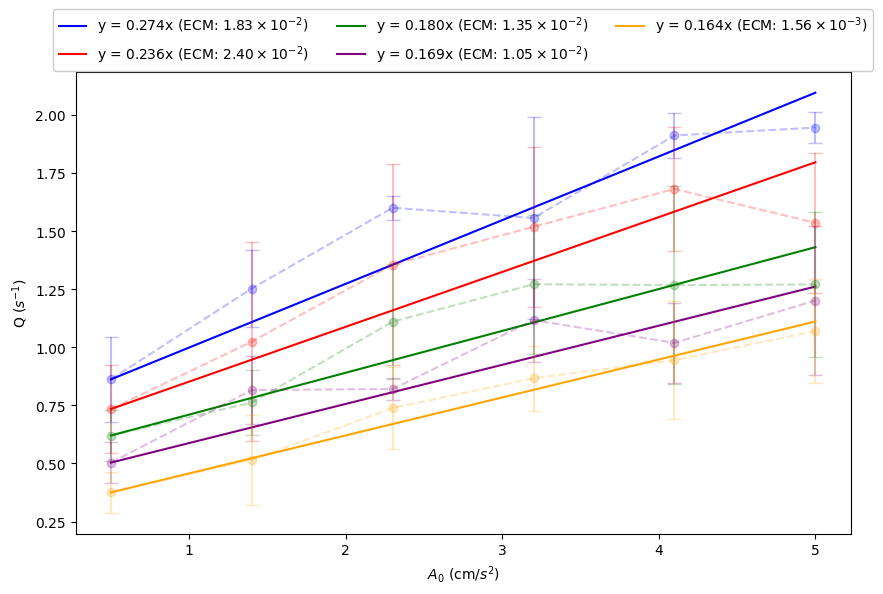

<Figure size 640x480 with 0 Axes>

In [14]:

plt.figure(figsize=(10, 6))
for i in range(len(M_VALUES)):
    plt.errorbar(A0_VALUES, c_q_means[i], yerr=c_q_std[i], fmt='--o', capsize=5, alpha=0.25, color=colors[i])
    plt.plot(A0_VALUES, [c_inv_resistance[i] * (a0 - A0_VALUES[0]) + c_q_means[i][0] for a0 in A0_VALUES],
             label=f"y = {c_inv_resistance[i]:.3f}x (ECM: {formatter(c_inv_resistance_ecm[i],None)})",
             color=colors[i],)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), framealpha=1.0, ncol=3)

# plt.subplots_adjust(top=0.95)
plt.xlabel("$A_0$ (cm/$s^2$)")
plt.ylabel("Q ($s^{-1}$)")

plt.savefig("../analysis/q_vs_a0_m_lines.png", dpi=300)
plt.show()
plt.clf()


In [15]:
c_resistance = 1 / c_inv_resistance
c_resistance_error = 1 / (c_resistance ** 2) * c_inv_resistance_ecm
print(c_resistance)
print(c_resistance_error)

[3.64351967 4.23250823 5.54594352 5.93173946 6.1121989 ]
[1.37635940e-03 1.34187017e-03 4.38616936e-04 2.99265083e-04
 4.17907928e-05]


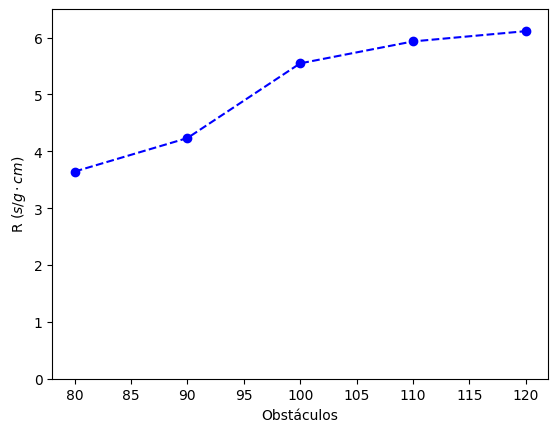

<Figure size 640x480 with 0 Axes>

In [16]:
# plt.errorbar(M_VALUES, c_resistance, yerr=c_resistance_error, fmt="o--", capsize=5 , color='blue')
plt.plot(M_VALUES, c_resistance, "o--", color='blue')
plt.xlabel("Obstáculos")
plt.ylabel("R ($g \\cdot cm/s$)")
plt.ylim(0, 6.5)

plt.savefig("../analysis/resistance_vs_m.png", dpi=300)
plt.show()
plt.clf()